In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from config import GameConfig
from enums import StartingSplit
from env import DefaultEnvironment
from mctsrunner import train_mcts
from mcts import GameTree 
from player import init_players

In [3]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')

In [5]:
tree_name = 'r-r-mcts-mlog-100k-score-v2'
rollout_name = 'mlog-100k-v2'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [6]:
config = GameConfig(split=StartingSplit.StartingRandomSplit, sandbox=True, num_players=2)
tree = GameTree(train=True)
# players = init_players(['UCT', 'BM'], tree=tree, rollout_type='mlog')
player = init_players(['UCT'], tree=tree, rollout_type='mlog')[0]
players = [player, player]
agent = players[0]
# opp = players[1]
env = DefaultEnvironment(config, players)

In [7]:
from aiutils import load

In [8]:
model_name = 'bm-bm-logistic-pred-1k-first-province'
model_path = os.path.join(model_dir, model_name)
model = load(model_path)

In [9]:
dataset_name = 'train-bm-bm-1k-full'
data_path = os.path.join(project_root, 'datasets', dataset_name)
raw_data = load(data_path)
X, y = raw_data[0], raw_data[1]
train_y = y.copy()
train_y[train_y<0] = 0

In [10]:
rollout = player.rollout
rollout.models[8] = model

In [11]:
idxs = {'Copper': 0, 'Curse': 1, 'Estate': 2, 'Duchy': 3, 'Province': 4, 'Silver': 5, 'Gold': 6}
cards = list(idxs.keys())

In [12]:
filtered_X_idxs = [(i, x) for i, x in enumerate(X) if x[idxs['Province']] > 6]
filtered_X_idxs = [list(t) for t in zip(*filtered_X_idxs)]
filtered_X = filtered_X_idxs[1]
filtered_y = train_y[filtered_X_idxs[0]]
assert len(filtered_X) == len(filtered_y)
len(filtered_y)

17506

In [13]:
for i, x in enumerate(filtered_X): 
    rollout.buffers[8].store(x, filtered_y[i])

In [13]:
rollout.train = False

In [14]:
train_mcts(env=env, tree=tree, epochs=100000, train_epochs_interval=500, save_epochs=1000, path=tree_path, rollout_path=rollout_path)

  1%|          | 538/100000 [00:57<2:56:35,  9.39it/s] 


KeyboardInterrupt: 

In [16]:
from mctsutils import *

In [17]:
node = tree._root
get_depth(node)

18

In [37]:
node = tree._root.children[0].children[0]

In [38]:
L = get_most_visited_paths_at_depth(node, 4, 10)

In [44]:
node.children[2].children

[None<--n: 3, v: 95, c: Copper-->['Copper', 'Estate', 'Duchy', 'Silver', 'None'],
 None<--n: 30, v: 1086, c: Estate-->['Copper', 'Estate', 'Duchy', 'Silver', 'None'],
 None<--n: 5, v: 153, c: None-->['Copper', 'Estate', 'Duchy', 'Silver', 'None']]

In [21]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

In [102]:
model_name = 'r-r-logistic-pred-1k-50'
model_path = os.path.join(model_dir, model_name)
plot_model = load(model_path)

<AxesSubplot:>

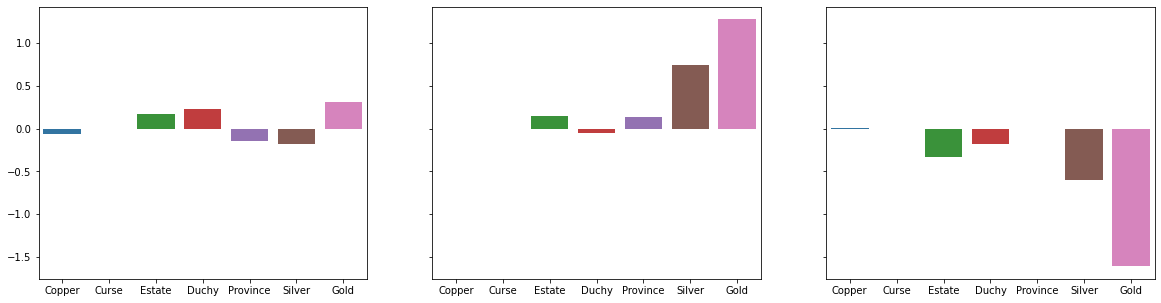

In [30]:
i=8
plot_model = player.rollout.models[i]
# plot_model = model

agent_weights = plot_model.coef_[0][7:14]
opp_weights = plot_model.coef_[0][14:]
supply_weights = plot_model.coef_[0][:7]
cards = list(env.game.state.feature.idxs.keys())

f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])

In [106]:
agent_weights_comp = plot_model.coef_[0][7:14]
opp_weights_comp = plot_model.coef_[0][14:]
supply_weights_comp = plot_model.coef_[0][:7]
cards = list(env.game.state.feature.idxs.keys())

<AxesSubplot:>

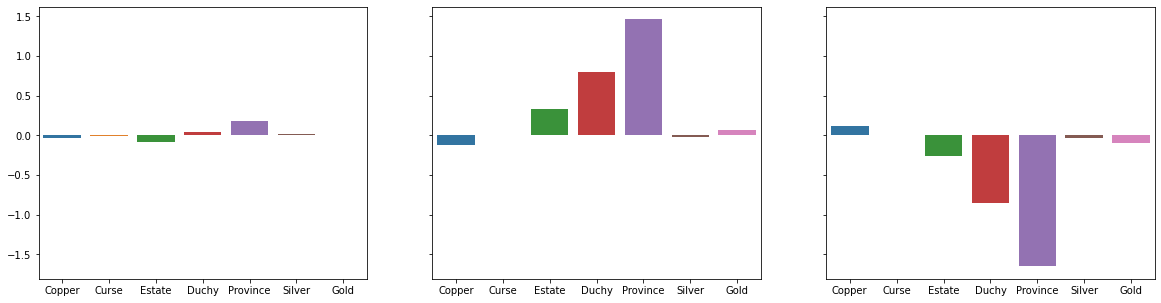

In [107]:
f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights_comp, ax=axes[0])
sns.barplot(x=cards, y=agent_weights_comp, ax=axes[1])
sns.barplot(x=cards, y=opp_weights_comp, ax=axes[2])